Import Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
from torch import nn
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from tqdm.notebook import tqdm
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split

In [ ]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Load the Dataset

In [ ]:
!cp -r drive/MyDrive/PlantVillage /content/PlantVillage
path = "/content/PlantVillage"

In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /content/PlantVillage


Number of total classes: 15
Potato___Early_blight
256
256


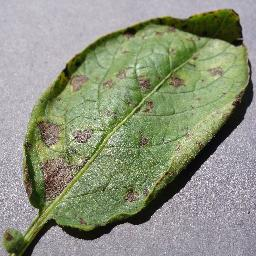

In [ ]:
classes = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

class_name = random.choice(classes)
class_path = os.path.join(path, class_name)

#filter only image file
valid_exts = (".jpg", ".jpeg", ".png")
img_files = [f for f in os.listdir(class_path) if f.lower().endswith(valid_exts)]

img_name = random.choice(img_files)
img_path = os.path.join(class_path, img_name)

img = Image.open(img_path)

print(f"Number of total classes: {len(classes)}")
print(class_name)
print(img.height)
print(img.width)

img

(256, 256, 3)


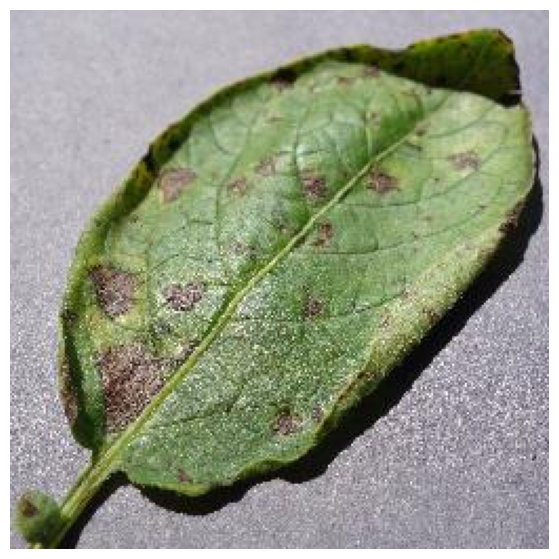

In [ ]:
img_as_array = np.asanyarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

print(img_as_array.shape)

Visualise Dataset transformation

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [ ]:
def visualize_transform(img_path, transform):
  img = Image.open(img_path)

  transformed_img = transform(img)

  if isinstance(transformed_img, torch.Tensor):
    transformed_img = transforms.ToPILImage()(transformed_img)

  fig, axes = plt.subplots(1, 2, figsize=(8,4))

  axes[0].imshow(img)
  axes[0].set_title("Original")
  axes[0].axis("off")

  axes[1].imshow(transformed_img)
  axes[1].set_title("Transformed")
  axes[1].axis("off")

  plt.show()

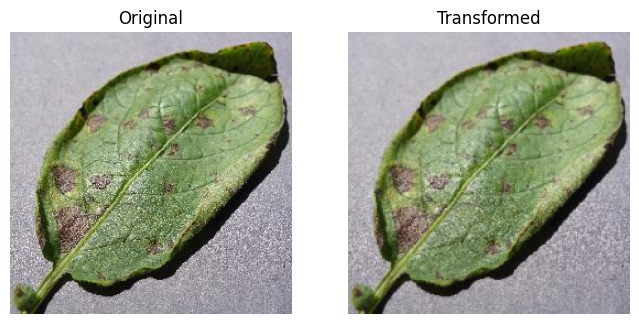

In [ ]:
class_name = random.choice(classes)
classs_path = os.path.join(path, class_name)
img_name = random.choice(os.listdir(class_path))
imag_path= os.path.join(class_path, img_name)

visualize_transform(img_path, data_transform)

Full Dataset Index

In [ ]:
full_dataset = datasets.ImageFolder(root=path, transform=None)
full_dataset

Dataset ImageFolder
    Number of datapoints: 20648
    Root location: /content/PlantVillage

In [ ]:
#class to index
class_to_idx = full_dataset.class_to_idx
classes = list(class_to_idx.keys())
classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
#Index to class
idx_to_class = {value: key for key, value in class_to_idx.items()}
idx_to_class

{0: 'Pepper__bell___Bacterial_spot',
 1: 'Pepper__bell___healthy',
 2: 'Potato___Early_blight',
 3: 'Potato___Late_blight',
 4: 'Potato___healthy',
 5: 'Tomato_Bacterial_spot',
 6: 'Tomato_Early_blight',
 7: 'Tomato_Late_blight',
 8: 'Tomato_Leaf_Mold',
 9: 'Tomato_Septoria_leaf_spot',
 10: 'Tomato_Spider_mites_Two_spotted_spider_mite',
 11: 'Tomato__Target_Spot',
 12: 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 13: 'Tomato__Tomato_mosaic_virus',
 14: 'Tomato_healthy'}

In [ ]:
targets = [label for _, label in full_dataset.samples]
print(f"Total images: {len(targets)}")

Total images: 20648


Split the dataset for Training and Testing

In [ ]:
train_idx, test_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    random_state=42,
    stratify=targets
)

In [ ]:
print(f"Number of Train images: {len(train_idx)} | Number of Test images: {len(test_idx)}")

Number of Train images: 16518 | Number of Test images: 4130


In [ ]:
calc_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

calc_full = datasets.ImageFolder(root=path, transform=calc_transform)
calc_train = Subset(calc_full, train_idx)

Find Mean and Standard Deviation

In [ ]:
def get_mean_std(dataset, batch_size=32, num_workers=2):
  loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
  rgb_sum = torch.zeros(3)
  rgb_sumsq = torch.zeros(3)
  count_pixels = 0

  for x, _ in loader:
    b, c, h, w = x.shape
    count_pixels += b * h * w
    rgb_sum += x.sum(dim=[0,2,3])
    rgb_sumsq += (x**2).sum(dim=[0,2,3])

  mean = rgb_sum / count_pixels
  std = torch.sqrt(rgb_sumsq / count_pixels - mean ** 2)
  return mean, std

In [ ]:
# Mean & std (important code)
# mean_tensor, std_tensor = get_mean_std(calc_train)
# mean = mean_tensor.tolist()
# std = std_tensor.tolist()

# print("Mean:", mean)
# print("Std:", std)

Mean: [0.45923691987991333, 0.4754456877708435, 0.4114924371242523]
Std: [0.18601608276367188, 0.16261300444602966, 0.20084309577941895]


Normalization

In [ ]:
mean = [0.45923691987991333, 0.4754456877708435, 0.4114924371242523]
std = [0.18601608276367188, 0.16261300444602966, 0.20084309577941895]

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_data_all = datasets.ImageFolder(root=path, transform=train_transform)
test_data_all = datasets.ImageFolder(root=path, transform=test_transform)

train_set = Subset(train_data_all, train_idx)
test_set = Subset(test_data_all, test_idx)

In [ ]:
len(train_set), len(test_set)

(16518, 4130)

Put in Data Loader

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_set, batch_size= BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size= BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
len(train_loader), len(test_loader)

(517, 130)

Training the Model: Convolutional Neural Network (CNN)

In [ ]:
# CNN Model Definition

class ImageClassifierCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=128*28*28, out_features=512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=512, out_features=num_classes)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.classifier(x)
    return x
    # return self.classifier(self.block3(self.block2(self.block1(x))))


In [ ]:
#Create Model
num_classes = 15

cnn_model = ImageClassifierCNN(num_classes=num_classes).to(device)
cnn_model

ImageClassifierCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_feature

In [ ]:
# Create Loss, Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

#Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

#Early Stopping Parameters
patience = 3
early_stop_counter = 0
best_test_loss = float("inf")
best_model_path = "/content/drive/My Drive/cnn_model.pth"


#Move model to GPU if available
cnn_model = cnn_model.to(device)

# Training and Evaluation Loop
EPOCHS = 20

for epoch in range(EPOCHS):

  # Training Phase
  cnn_model.train()
  running_loss, correct, total = 0.0, 0, 0

  # tqdm progress bar
  for batch_idx, (X_batch, y_batch) in enumerate (tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)):
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    #forward pass
    y_pred = cnn_model(X_batch)
    loss = loss_fn(y_pred, y_batch)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #running metrics
    running_loss += loss.item()
    _, predicted = torch.max(y_pred, 1)
    total += y_batch.size(0)
    correct += (predicted == y_batch).sum().item()

    #batch-wise loss print every 50 batches
    if batch_idx % 50 == 0:
        tqdm.write(f"Batch {batch_idx}: Loss={loss.item():.4f}")

  #Epoch-wise metrics
  train_acc = 100 * correct / total
  avg_loss = running_loss / len(train_loader)

  # Evaluation Phase
  cnn_model.eval()
  test_correct, test_total, test_loss_total = 0, 0, 0.0

  with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            test_pred = cnn_model(X_batch)
            test_loss = loss_fn(test_pred, y_batch)

            test_loss_total += test_loss.item()
            _, predicted = torch.max(test_pred, 1)
            test_total += y_batch.size(0)
            test_correct += (predicted == y_batch).sum().item()

  test_acc = 100 * test_correct / test_total
  avg_loss = test_loss_total / len(test_loader)

  #Learning rate scheduling
  scheduler.step(avg_loss)
  #print epoch summary
  print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_loss:.4f} | "
        f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | "
        f"Learning rate now: {optimizer.param_groups[0]['lr']}")

  #Early stopping check
  if avg_loss < best_test_loss:
    best_test_loss = avg_loss
    early_stop_counter = 0
    torch.save(cnn_model.state_dict(), best_model_path) #best model save
    print(f"Best model saved at epoch {epoch+1}")
  else:
    early_stop_counter += 1
    print(f"No improvement. Patience counter: {early_stop_counter}/{patience}")
    if early_stop_counter >= patience:
      print("Early stopping triggered!")
      break


Epoch 1/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=2.7115
Batch 50: Loss=2.5269
Batch 100: Loss=1.9734
Batch 150: Loss=1.6099
Batch 200: Loss=1.7743
Batch 250: Loss=1.1994
Batch 300: Loss=1.3728
Batch 350: Loss=1.4834
Batch 400: Loss=1.5899
Batch 450: Loss=0.9404
Batch 500: Loss=1.1195
Epoch [1/20] | Train Loss: 1.1447 | Train Acc: 47.17% | Test Acc: 63.34% | Learning rate now: 0.001
Best model saved at epoch 1


Epoch 2/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.8731
Batch 50: Loss=1.0149
Batch 100: Loss=0.9693
Batch 150: Loss=0.6390
Batch 200: Loss=0.6261
Batch 250: Loss=0.7360
Batch 300: Loss=0.8889
Batch 350: Loss=1.0526
Batch 400: Loss=0.7215
Batch 450: Loss=1.0756
Batch 500: Loss=0.7808
Epoch [2/20] | Train Loss: 0.7927 | Train Acc: 70.01% | Test Acc: 74.89% | Learning rate now: 0.001
Best model saved at epoch 2


Epoch 3/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.6976
Batch 50: Loss=0.9824
Batch 100: Loss=0.7533
Batch 150: Loss=0.7396
Batch 200: Loss=0.7671
Batch 250: Loss=1.0927
Batch 300: Loss=0.8008
Batch 350: Loss=0.5771
Batch 400: Loss=0.4075
Batch 450: Loss=0.4769
Batch 500: Loss=0.4896
Epoch [3/20] | Train Loss: 0.4762 | Train Acc: 78.06% | Test Acc: 84.36% | Learning rate now: 0.001
Best model saved at epoch 3


Epoch 4/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.4892
Batch 50: Loss=0.7751
Batch 100: Loss=0.5729
Batch 150: Loss=0.3374
Batch 200: Loss=0.3341
Batch 250: Loss=0.4906
Batch 300: Loss=0.6153
Batch 350: Loss=0.7579
Batch 400: Loss=0.6215
Batch 450: Loss=0.3811
Batch 500: Loss=0.4954
Epoch [4/20] | Train Loss: 0.3378 | Train Acc: 83.55% | Test Acc: 88.96% | Learning rate now: 0.001
Best model saved at epoch 4


Epoch 5/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.4110
Batch 50: Loss=0.2683
Batch 100: Loss=0.1862
Batch 150: Loss=0.5989
Batch 200: Loss=0.5658
Batch 250: Loss=0.7374
Batch 300: Loss=0.5300
Batch 350: Loss=0.3228
Batch 400: Loss=0.3832
Batch 450: Loss=0.5469
Batch 500: Loss=0.5757
Epoch [5/20] | Train Loss: 0.2977 | Train Acc: 86.81% | Test Acc: 90.27% | Learning rate now: 0.001
Best model saved at epoch 5


Epoch 6/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.3334
Batch 50: Loss=0.3487
Batch 100: Loss=0.7327
Batch 150: Loss=0.4448
Batch 200: Loss=0.4302
Batch 250: Loss=0.2960
Batch 300: Loss=0.4869
Batch 350: Loss=0.2926
Batch 400: Loss=0.2130
Batch 450: Loss=0.4534
Batch 500: Loss=0.1250
Epoch [6/20] | Train Loss: 0.2455 | Train Acc: 88.70% | Test Acc: 91.57% | Learning rate now: 0.001
Best model saved at epoch 6


Epoch 7/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.5801
Batch 50: Loss=0.2887
Batch 100: Loss=0.4148
Batch 150: Loss=0.2401
Batch 200: Loss=0.1811
Batch 250: Loss=0.2171
Batch 300: Loss=0.5781
Batch 350: Loss=0.5119
Batch 400: Loss=0.0975
Batch 450: Loss=0.1938
Batch 500: Loss=0.2607
Epoch [7/20] | Train Loss: 0.2491 | Train Acc: 90.29% | Test Acc: 91.99% | Learning rate now: 0.001
No improvement. Patience counter: 1/3


Epoch 8/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.4778
Batch 50: Loss=0.2133
Batch 100: Loss=0.1931
Batch 150: Loss=0.1346
Batch 200: Loss=0.3894
Batch 250: Loss=0.2209
Batch 300: Loss=0.1693
Batch 350: Loss=0.2960
Batch 400: Loss=0.3695
Batch 450: Loss=0.3229
Batch 500: Loss=0.6569
Epoch [8/20] | Train Loss: 0.1893 | Train Acc: 90.44% | Test Acc: 93.49% | Learning rate now: 0.001
Best model saved at epoch 8


Epoch 9/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.3498
Batch 50: Loss=0.2116
Batch 100: Loss=0.2834
Batch 150: Loss=0.5097
Batch 200: Loss=0.4548
Batch 250: Loss=0.1356
Batch 300: Loss=0.4389
Batch 350: Loss=0.2655
Batch 400: Loss=0.1892
Batch 450: Loss=0.1061
Batch 500: Loss=0.2848
Epoch [9/20] | Train Loss: 0.2025 | Train Acc: 92.06% | Test Acc: 93.24% | Learning rate now: 0.001
No improvement. Patience counter: 1/3


Epoch 10/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.2426
Batch 50: Loss=0.2129
Batch 100: Loss=0.3740
Batch 150: Loss=0.2682
Batch 200: Loss=0.4847
Batch 250: Loss=0.0596
Batch 300: Loss=0.0823
Batch 350: Loss=0.3207
Batch 400: Loss=0.0844
Batch 450: Loss=0.2640
Batch 500: Loss=0.1143
Epoch [10/20] | Train Loss: 0.2216 | Train Acc: 92.61% | Test Acc: 92.71% | Learning rate now: 0.001
No improvement. Patience counter: 2/3


Epoch 11/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.1520
Batch 50: Loss=0.2162
Batch 100: Loss=0.3268
Batch 150: Loss=0.1722
Batch 200: Loss=0.1218
Batch 250: Loss=0.1599
Batch 300: Loss=0.0470
Batch 350: Loss=0.1407
Batch 400: Loss=0.3756
Batch 450: Loss=0.1952
Batch 500: Loss=0.1630
Epoch [11/20] | Train Loss: 0.1626 | Train Acc: 92.60% | Test Acc: 94.75% | Learning rate now: 0.001
Best model saved at epoch 11


Epoch 12/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.2891
Batch 50: Loss=0.1085
Batch 100: Loss=0.0573
Batch 150: Loss=0.0357
Batch 200: Loss=0.1078
Batch 250: Loss=0.3450
Batch 300: Loss=0.1977
Batch 350: Loss=0.2462
Batch 400: Loss=0.2428
Batch 450: Loss=0.3498
Batch 500: Loss=0.0856
Epoch [12/20] | Train Loss: 0.1699 | Train Acc: 93.56% | Test Acc: 94.26% | Learning rate now: 0.001
No improvement. Patience counter: 1/3


Epoch 13/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.4694
Batch 50: Loss=0.1654
Batch 100: Loss=0.0866
Batch 150: Loss=0.0596
Batch 200: Loss=0.2039
Batch 250: Loss=0.1751
Batch 300: Loss=0.0159
Batch 350: Loss=0.2674
Batch 400: Loss=0.2628
Batch 450: Loss=0.1963
Batch 500: Loss=0.0910
Epoch [13/20] | Train Loss: 0.1452 | Train Acc: 94.19% | Test Acc: 94.96% | Learning rate now: 0.001
Best model saved at epoch 13


Epoch 14/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.1458
Batch 50: Loss=0.1613
Batch 100: Loss=0.2338
Batch 150: Loss=0.0969
Batch 200: Loss=0.2326
Batch 250: Loss=0.2050
Batch 300: Loss=0.0514
Batch 350: Loss=0.2585
Batch 400: Loss=0.1350
Batch 450: Loss=0.1134
Batch 500: Loss=0.2637
Epoch [14/20] | Train Loss: 0.1782 | Train Acc: 94.32% | Test Acc: 93.75% | Learning rate now: 0.001
No improvement. Patience counter: 1/3


Epoch 15/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.1643
Batch 50: Loss=0.0966
Batch 100: Loss=0.1377
Batch 150: Loss=0.3952
Batch 200: Loss=0.1720
Batch 250: Loss=0.7007
Batch 300: Loss=0.1111
Batch 350: Loss=0.6921
Batch 400: Loss=0.2776
Batch 450: Loss=0.0875
Batch 500: Loss=0.2790
Epoch [15/20] | Train Loss: 0.2160 | Train Acc: 94.48% | Test Acc: 92.91% | Learning rate now: 0.001
No improvement. Patience counter: 2/3


Epoch 16/20:   0%|          | 0/517 [00:00<?, ?it/s]

Batch 0: Loss=0.2751
Batch 50: Loss=0.0629
Batch 100: Loss=0.0588
Batch 150: Loss=0.1375
Batch 200: Loss=0.0841
Batch 250: Loss=0.0882
Batch 300: Loss=0.0269
Batch 350: Loss=0.0200
Batch 400: Loss=0.1271
Batch 450: Loss=0.0725
Batch 500: Loss=0.0962
Epoch [16/20] | Train Loss: 0.1765 | Train Acc: 95.08% | Test Acc: 94.46% | Learning rate now: 0.0005
No improvement. Patience counter: 3/3
Early stopping triggered!


Prediction Pipeline

In [ ]:
#Load Trained model
num_classes = num_classes
cnn_model = ImageClassifierCNN(num_classes=num_classes)
cnn_model.load_state_dict(torch.load(best_model_path, map_location=device))
cnn_model = cnn_model.to(device)
cnn_model.eval()   # put into inference mode
print("Model loaded and ready for inference.")

Model loaded and ready for inference.


In [ ]:
#define same transformations
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
#Load an image for testing
pred_img_path = "/content/PlantVillage/Tomato_Leaf_Mold/02a29ab9-8cba-47a0-bc2f-e7af7dbae149___Crnl_L.Mold 7165.JPG"
pred_img = read_image(pred_img_path).type(torch.float32)
pred_img

tensor([[[101., 102., 105.,  ...,  84.,  99., 102.],
         [103.,  96.,  94.,  ..., 100., 108., 100.],
         [ 97.,  98.,  92.,  ...,  95., 110., 111.],
         ...,
         [136., 119., 118.,  ..., 120., 118., 118.],
         [127., 113., 114.,  ..., 130., 127., 126.],
         [122., 118., 125.,  ..., 126., 127., 126.]],

        [[102., 103., 106.,  ...,  85., 100., 103.],
         [104.,  97.,  95.,  ..., 101., 109., 101.],
         [ 98.,  99.,  93.,  ...,  96., 111., 112.],
         ...,
         [141., 124., 123.,  ..., 125., 123., 123.],
         [132., 118., 119.,  ..., 135., 132., 131.],
         [127., 123., 130.,  ..., 131., 132., 131.]],

        [[122., 123., 126.,  ..., 103., 118., 121.],
         [124., 117., 115.,  ..., 119., 127., 119.],
         [118., 119., 113.,  ..., 114., 129., 130.],
         ...,
         [161., 144., 143.,  ..., 145., 143., 143.],
         [152., 138., 139.,  ..., 155., 152., 151.],
         [147., 143., 150.,  ..., 151., 152., 151.]]]

In [ ]:
#load image with PIL
pred_img = Image.open(pred_img_path)

#apply transforms
pred_img = test_transform(pred_img)
pred_img = pred_img.unsqueeze(0).to(device)

In [ ]:
#Prediction
cnn_model.eval()
with torch.inference_mode():
  prediction = cnn_model(pred_img)
prediction

tensor([[-11.9529, -11.6084, -15.4925, -10.2551, -28.4046, -12.6163,  -2.3706,
           4.2428,  15.2068,   0.6997,  -5.8955, -15.9520,  -3.3890,  -5.5701,
          -8.3531]], device='cuda:0')

In [ ]:
#prediction probabilities using softmax
pred_probabilities = torch.softmax(prediction, dim=1)

#Get the prediction class index
pred_idx = torch.argmax(pred_probabilities, dim=1).item()

#Get the prediction class label
pred_label = idx_to_class[pred_idx]

#print results
print(f"Prediction probabilities:", pred_probabilities.squeeze().tolist())
print(f"Predicted class index:", pred_idx)
print(f"Predicted class label:", pred_label)

Prediction probabilities: [1.6022178158867084e-12, 2.261131819975004e-12, 4.650371477872908e-14, 8.750879361418828e-12, 1.1477432144615017e-19, 8.252577766119928e-13, 2.324127734709691e-08, 1.7314421711489558e-05, 0.9999822378158569, 5.008020593777474e-07, 6.845188305071304e-10, 2.9372239639417416e-14, 8.394232864361584e-09, 9.477661988555042e-10, 5.862305085813091e-11]
Predicted class index: 8
Predicted class label: Tomato_Leaf_Mold
